In [ ]:
import os
import math
import random
import shutil
from shutil import copy2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Устанавливаем датасет

In [ ]:
!unzip /content/drive/MyDrive/CoMNIST1.zip -d /content/q

In [ ]:
# Каталог с набором данных
data_dir = "/content/dataset"
# Каталог с данными для обучения
train_dir = '/content/dataset/train'
# Каталог с данными для проверки
val_dir = '/content/dataset/val'
# Каталог с данными для тестирования
test_dir = '/content/dataset/test'

### Деление датасета



In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
input_folder = "/content/q/CoMNIST1"
splitfolders.ratio(input_folder, "/content/dataset", ratio=(0.70, 0.15, 0.15), seed=2)

Copying files: 123583 files [00:24, 5003.39 files/s]


##Создание датасетов и их кеширование

In [ ]:
batch_size = 8
img_width = 32
img_height = 32

train_ds = image_dataset_from_directory(train_dir,
                                             subset='training',
                                             seed=123,
                                             validation_split=0.3,
                                             batch_size=batch_size,
                                             image_size=(img_height, img_width))

val_ds = image_dataset_from_directory(val_dir,
																							subset='validation',
																							seed=123,
																							validation_split=0.3,
																							batch_size=batch_size,
																							image_size=(img_height, img_width))

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 86487 files belonging to 48 classes.
Using 60541 files for training.
Found 18513 files belonging to 48 classes.
Using 5553 files for validation.
Class names: ['!', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']


##Решение проблемы переобучения.

In [ ]:
model = Sequential([
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.15),
	layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Dropout(0.3),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(48)
])

model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

model.summary()

##Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох обучения

Epoch 1/50
3784/3784 [==============================] - 86s 23ms/step - loss: 0.9906 - accuracy: 0.6975 - val_loss: 0.6289 - val_accuracy: 0.8001
Epoch 2/50
3784/3784 [==============================] - 87s 23ms/step - loss: 0.9085 - accuracy: 0.7223 - val_loss: 0.5160 - val_accuracy: 0.8367
Epoch 3/50
3784/3784 [==============================] - 84s 22ms/step - loss: 0.8615 - accuracy: 0.7352 - val_loss: 0.5776 - val_accuracy: 0.8217
Epoch 4/50
3784/3784 [==============================] - 87s 23ms/step - loss: 0.8166 - accuracy: 0.7470 - val_loss: 0.4876 - val_accuracy: 0.8449
Epoch 5/50
3784/3784 [==============================] - 84s 22ms/step - loss: 0.7830 - accuracy: 0.7584 - val_loss: 0.5349 - val_accuracy: 0.8365
Epoch 6/50
3784/3784 [==============================] - 85s 23ms/step - loss: 0.7558 - accuracy: 0.7681 - val_loss: 0.5241 - val_accuracy: 0.8356
Epoch 7/50
3784/3784 [==============================] - 87s 23ms/step - loss: 0.7415 - accuracy: 0.7704 - val_loss: 0.5415 -

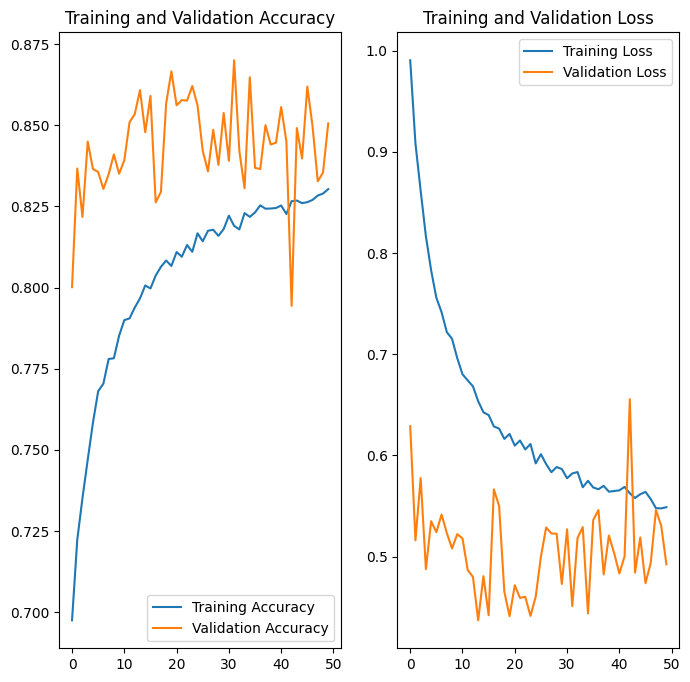

In [ ]:
epochs = 50

# Создаем папку для сохранения моделей
checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),
    save_freq='epoch',
    save_weights_only=False,
    period=5
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint_callback]
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Делаем инференс на новом изображении

In [ ]:
from keras.preprocessing import image
model_dir = '/content/model_checkpoints1'

# Путь к папке с изображениями
image_dir = "/content/drive/MyDrive/letters/letters"
#image_dir = "/content/drive/MyDrive/letters_test_polina"
image_files = os.listdir(image_dir)

imgs = []
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    if os.path.isfile(image_path):
        img = image.load_img(image_path, target_size=(28, 28))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        imgs.append(img_array)

imgs_batch = np.vstack(imgs)

model_files = os.listdir(model_dir)
model_files.sort()

for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    if os.path.isfile(model_path) and model_file.endswith('.h5'):
        print(f"Проверка модели: {model_path}")
        loaded_model = load_model(model_path)
        predictions = loaded_model.predict(imgs_batch)
        correct_count = 0
        incorrect_count = 0
        for i, pred in enumerate(predictions):
            score = tf.nn.softmax(pred)
            predicted_letter = class_names[np.argmax(score)]
            expected_letter = image_files[i].split('.')[0][0]
            probability = 100 * np.max(score)
            # print(f"На изображении {image_files[i]} предсказано: {predicted_letter}, ожидалось: {expected_letter} ({probability:.2f}% вероятность)")
            if predicted_letter == expected_letter:
                correct_count += 1
            else:
                incorrect_count += 1

        print(f"Верных ответов: {correct_count}, неверных ответов: {incorrect_count}")
        print("-" * 30)
